In [47]:
import numpy as np
import matplotlib.pyplot as plt

we define the moment when the demande curve is changing

In [48]:
T=1000
t_change = [0] #the index when there is a change in the demande curve
n=0
while (n < T):
    k = np.random.randint(20,T/8)
    n += k
    t_change.append(n)
if (t_change[-1] > T):
    t_change[-1] = T
print(t_change)
N_change = len(t_change)
print(N_change)

[0, 80, 171, 280, 319, 379, 399, 475, 520, 589, 620, 734, 788, 841, 870, 913, 1000]
17


we define the different demande curves for each interval

In [49]:
K = 20
prices = np.linspace(0,1,K) #set of possible price p
coef = np.random.uniform(0.5,3,N_change)
conversion_probability_by_interval = np.zeros((N_change,K))
for i in range(N_change):
    conversion_probability_by_interval[i] = (np.ones(K)-coef[i]*prices)*(np.ones(K)-coef[i]*prices >0)

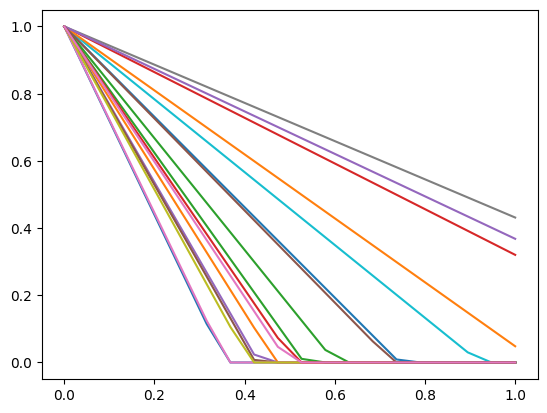

In [50]:
for i in range(N_change):
    plt.plot(prices,conversion_probability_by_interval[i])

Add noise to the demand curves

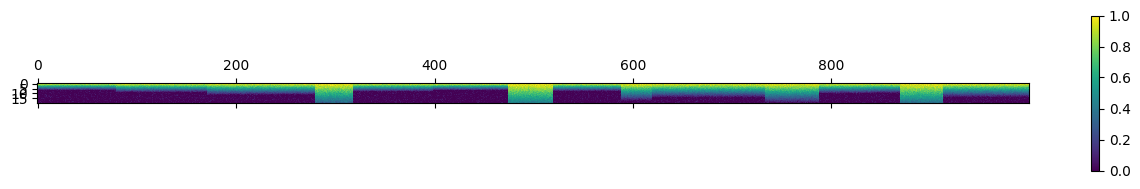

In [51]:
conversion_probability = np.zeros((T,K))
for i in range(N_change-1):
    for k in range((t_change[i+1] - t_change[i])):
        noise = np.random.normal(0,0.03, K) #  μ = 0, σ = 0.05, size = length of prices set
        noisy_demand = conversion_probability_by_interval[i] + noise
        for j in range(K):
            conversion_probability[t_change[i]+k][j] = max(0, min(1, noisy_demand[j])) # clip the value between 0 and 1

plt.matshow(conversion_probability.T)
plt.colorbar()


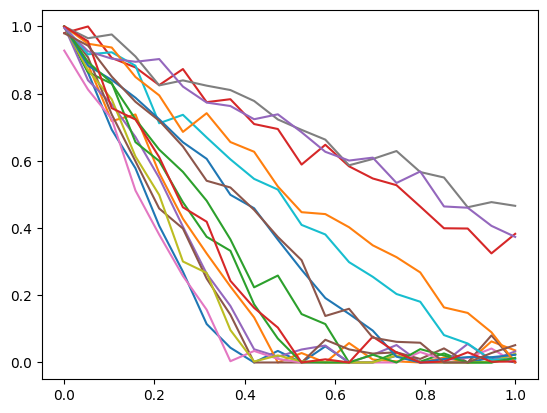

In [52]:
for t in range(N_change-1):
    plt.plot(prices,conversion_probability[t_change[t]])

Convert demand curves to reward sequences

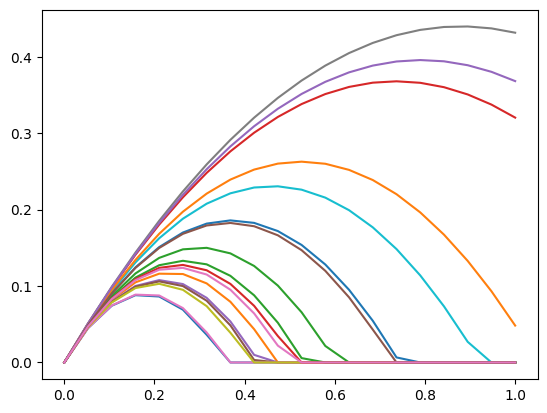

In [53]:
cost = 0
reward_sequence_by_interval = conversion_probability_by_interval*(prices-cost)
for i in range(N_change):
    plt.plot(prices,reward_sequence_by_interval[i])

we define the reward sequence for all t in 0:T and the Best ARM in hindsight (adversarial clairvoyance!!!)

Cumulative rewards for every arm: [  0.          47.71094578  85.85405391 114.1400021  132.65748648
 141.92046355 140.76246904 133.34000326 122.12928767 114.36496054
 106.23277059  98.53720645  90.88545751  83.29052673  75.31365269
  71.80298657  70.12093797  67.26932921  63.55772903  60.26219504]
Best arm in hindsight: 5
Best reward in hindsight: 141.92046354975687


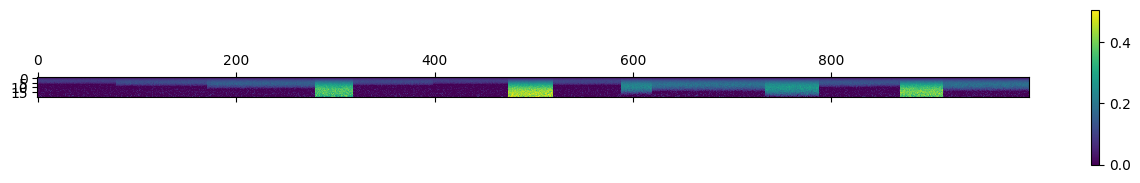

In [54]:
reward_sequence = conversion_probability*(prices-cost)

plt.matshow(reward_sequence.T)
plt.colorbar()

rew_cum = reward_sequence.sum(axis=0)
best_arm = np.argmax(rew_cum)
print(f'Cumulative rewards for every arm: {rew_cum}')
print(f'Best arm in hindsight: {best_arm}')
print(f'Best reward in hindsight: {rew_cum[best_arm]}')


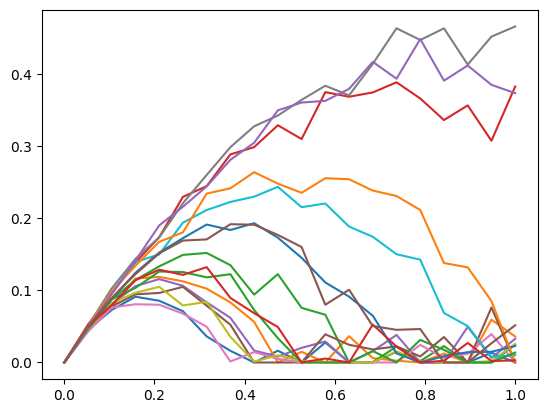

In [55]:
for t in range(N_change-1):
    plt.plot(prices,reward_sequence[t_change[t]])

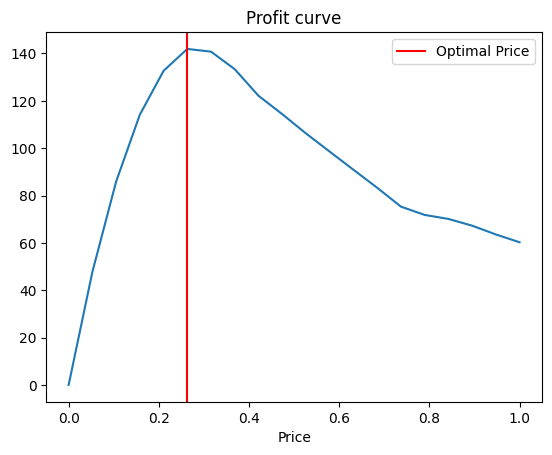

In [56]:
plt.plot(prices,rew_cum)
plt.axvline(prices[best_arm], color='red',label='Optimal Price')
plt.title('Profit curve')
plt.xlabel('Price')
plt.legend()
plt.show()

we define now the best POLICY cumulative reward (non-stationary stochastic clairvoyant)

In [57]:
# Best policy in Hindsight:
best_rewards = reward_sequence.max(axis=1) # we take the max over every single round
best_cum_rew = sum(best_rewards)
best_policy = reward_sequence.argmax(axis=1)
print(f'Best possible cumulative reward: {best_cum_rew}') # is higher than the cumulative reward of the best arm in hindsight

Best possible cumulative reward: 184.97157846473183


Where do we need to add the noise ?

In [58]:
class NonstationaryEnvironment:
    def __init__(self, conversion_probability, prices, cost, seed):
        np.random.seed(seed)
        self.conversion_probability = np.array(conversion_probability)
        self.cost = cost
        self.prices = prices
        self.rewards = np.random.binomial(n=1, p=self.conversion_probability)*(prices-cost)
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

(1000, 20)


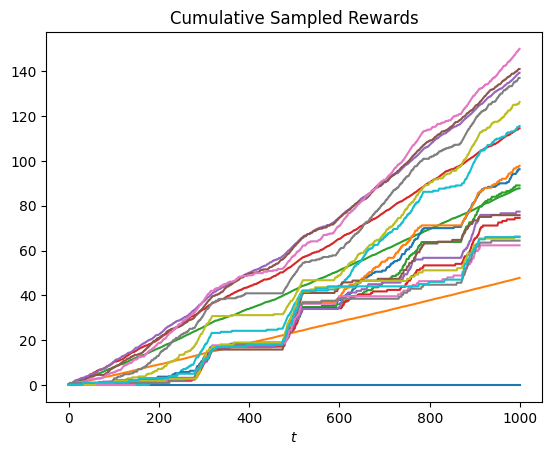

In [59]:
env = NonstationaryEnvironment(conversion_probability, prices,cost, seed=17)
print(env.rewards.shape)
plt.plot(np.arange(T), env.rewards.cumsum(axis=0))
plt.xlabel('$t$')
plt.title('Cumulative Sampled Rewards')
plt.show()

In [60]:
print(env.rewards.cumsum(axis=0).round())

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]
 ...
 [ 0. 48. 88. ... 64. 66. 66.]
 [ 0. 48. 88. ... 64. 66. 66.]
 [ 0. 48. 88. ... 64. 66. 66.]]


In [61]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

In [62]:
len(np.array(reward_sequence).max(axis=0))

20

In [63]:
U_T = 50 # maximum number of abrupt changes
W = int(2*np.sqrt(T*np.log(T)/U_T)) # assuming U_T is known
# W = int(2*np.sqrt(np.log(T))) # if U_T is unknown (i.e., set U_T=T)

expected_clairvoyant_rewards = np.array(reward_sequence).max(axis=1)

n_trials = 20

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryEnvironment(conversion_probability, prices,cost, seed)
    ucb_agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    
regret_per_trial = np.array(regret_per_trial)

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_13932\2771695725.py:17: RuntimeWarning: Mean of empty slice
  avg_last_w = np.nanmean(self.cache, axis=0)
C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_13932\2771695725.py:18: RuntimeWarning: divide by zero encountered in divide
  ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)


Text(0.5, 1.0, 'Clairvoyant Rewards')

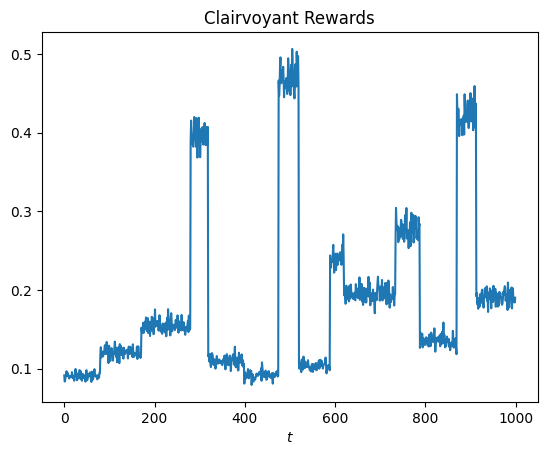

In [64]:
plt.plot(np.arange(T), expected_clairvoyant_rewards)
plt.xlabel('$t$')
plt.title('Clairvoyant Rewards')

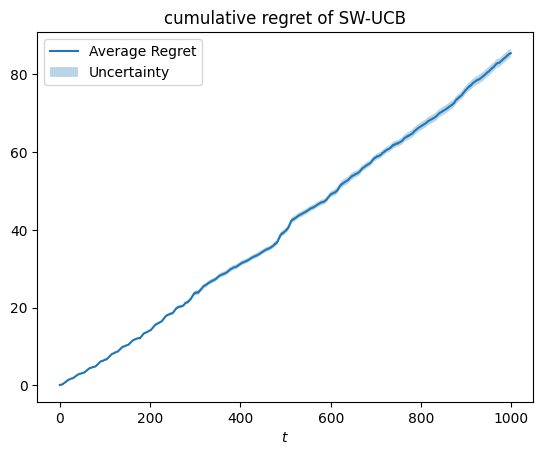

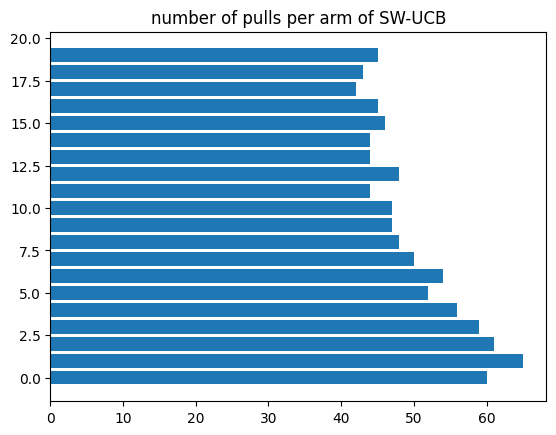

In [65]:
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SW-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(np.arange(K), width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of SW-UCB')
plt.show()

In [66]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0
    
    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1 
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t 
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False

In [67]:
h = 2*np.log(T/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(T/U_T)/T) # probability of extra exploration

M = int(np.log(T/U_T)) # robustness of change detection
# M = int(np.sqrt(T)) # usually keep M in [log(T/U_T), sqrt(T/U_T)]

expected_clairvoyant_rewards = np.array(reward_sequence).max(axis=1)

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryEnvironment(conversion_probability,prices,cost, seed)
    ucb_agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

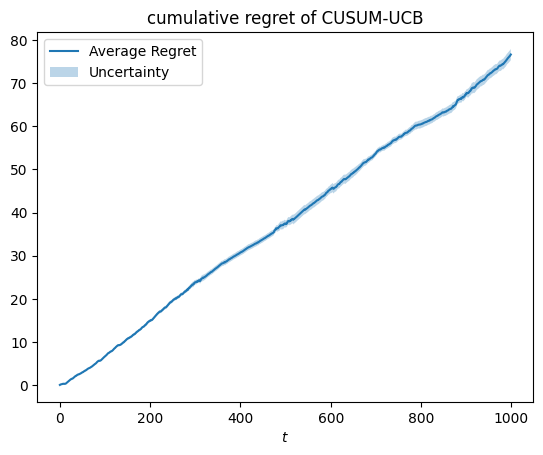

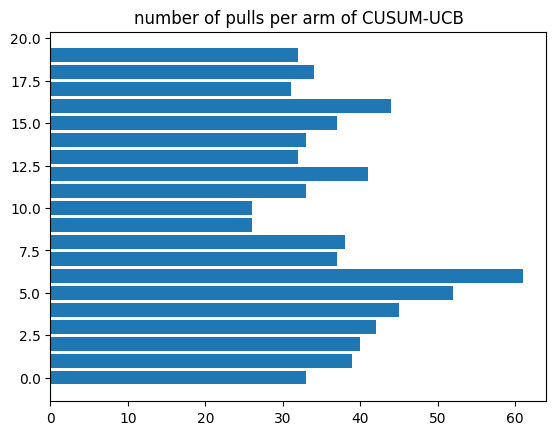

In [68]:
average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUM-UCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(np.arange(K), width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of CUSUM-UCB')
plt.show()